# The Wilson-Cowan model

The Wilson–Cowan model considers a homogeneous population of interconnected neurons of excitatory and inhibitory subtypes. All cells receive the same number of excitatory and inhibitory afferents, that is, all cells receive the same average excitation, $x(t)$. The target is to analyze the evolution in time of number of excitatory and inhibitory cells firing at time $t$,
$E(t)$ and $I(t)$ respectively.


## Background / Theory

### The Wilson-Cowan Model

The **Wilson-Cowan model** (1972) is a foundational neural mass model describing the interaction between excitatory (E) and inhibitory (I) neural populations. It was one of the first models to capture emergent oscillatory dynamics from E/I balance.

### The Equations

$$
\begin{aligned}
\tau_E \frac{dr_E}{dt} &= -r_E + (1 - r \cdot r_E) \cdot F_E(w_{EE} r_E - w_{EI} r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + (1 - r \cdot r_I) \cdot F_I(w_{IE} r_E - w_{II} r_I + I_I)
\end{aligned}
$$

where:
- $r_E, r_I$: Excitatory and inhibitory population activities
- $\tau_E, \tau_I$: Time constants
- $w_{XY}$: Connection weights from population Y to X
- $r$: Refractory parameter (limits maximum firing)
- $I_E, I_I$: External inputs

### The Sigmoid Transfer Function

$$
F(x; a, \theta) = \frac{1}{1 + e^{-a(x - \theta)}} - \frac{1}{1 + e^{a\theta}}
$$

| Parameter | Role |
|-----------|------|
| $a$ | Gain (steepness of response) |
| $\theta$ | Threshold (input level for half-activation) |

### Connection Weights

| Weight | Meaning | Typical Effect |
|--------|---------|----------------|
| $w_{EE}$ | E→E recurrence | Positive feedback, bistability |
| $w_{EI}$ | I→E inhibition | Negative feedback, stabilization |
| $w_{IE}$ | E→I excitation | Drives inhibition |
| $w_{II}$ | I→I recurrence | Self-inhibition |

### Dynamical Regimes

The Wilson-Cowan model exhibits rich dynamics:

1. **Stable fixed points**: E/I balance at rest
2. **Limit cycle oscillations**: Rhythmic E/I alternation
3. **Bistability**: Multiple stable states
4. **Excitable dynamics**: Transient responses to perturbations

### Parameter "Knobs" - Biological Interpretation

Each parameter in the Wilson-Cowan model corresponds to a biological or functional "knob" that can be tuned to produce different neural dynamics. Understanding these mappings is crucial for relating model behavior to neuroscience.


| Parameter | Knob Name | Biological Correspondence | Effect Range |
|-----------|-----------|---------------------------|--------------|
| $\tau_E, \tau_I$ | Response Speed | Membrane time constant, ion channel kinetics | Fast (1ms) → Slow (10ms) |
| $a_E, a_I$ | Neural Gain | Synaptic efficacy, neurotransmitter sensitivity | 0.5 (sluggish) → 2.0 (sensitive) |
| $\theta_E, \theta_I$ | Activation Threshold | Firing threshold voltage | 1.0 (easy to activate) → 5.0 (hard to activate) |
| $w_{EE}$ | Recurrent Excitation | AMPA/NMDA strength within E population | 0-20 |
| $w_{EI}$ | Feedback Inhibition | GABAergic strength I→E | 0-20 |
| $w_{IE}$ | Feedforward Excitation | Glutamatergic drive to inhibition | 0-10 |
| $w_{II}$ | Recurrent Inhibition | GABAergic self-inhibition within I | 0-15 |
| $r$ | Refractory Period | Sodium channel inactivation | 0 (none) → 2 (strong) |


These combinations of parameters control higher-level system properties:

**1. E/I Balance Knob** ($w_{EE} / w_{EI}$ ratio):
- **High ratio (>1.0)**: Excitation-dominant system, risk of runaway activity (epileptiform)
- **Balanced (~0.9)**: Stable limit-cycle oscillations (gamma rhythms)
- **Low ratio (<0.8)**: Over-stabilized system, suppressed dynamics

**2. Timescale Separation Knob** ($\tau_I / \tau_E$):
- **$\tau_I \gg \tau_E$**: Slow inhibition relative to excitation → beta/gamma rhythms
- **$\tau_I \approx \tau_E$**: Symmetric dynamics → alpha rhythms
- **$\tau_I \ll \tau_E$**: Fast inhibition → high-frequency filtering

**3. Excitability Knob** ($a_E, \theta_E$):
- **High $a_E$, low $\theta_E$**: Hyperexcitable regime (epilepsy models)
- **Low $a_E$, high $\theta_E$**: Hypoexcitable regime (anesthesia models)
- **Intermediate**: Normal awake cortical states

These "knobs" provide an intuitive interface for parameter exploration while maintaining biological interpretability.



In [ ]:
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import brainmass

plt.rcParams['image.cmap'] = 'plasma'

In [ ]:
brainstate.environ.set(dt=0.1 * u.ms)

Environment:
- `dt = 0.1 ms` sets the integration time step for all updates.
- We will rely on `brainstate.transform.for_loop` to advance the model efficiently.

## Single node simulation

We instantiate one Wilson–Cowan node with OU noise on both E and I. The `step_run(i)` helper advances the model one time step with a proper `(i, t)` context. The node returns the current excitatory rate `rE`.

In [38]:
node = brainmass.WilsonCowanStep(
    1,
    noise_E=brainmass.OUProcess(1, sigma=0.01, init=braintools.init.ZeroInit()),
    noise_I=brainmass.OUProcess(1, sigma=0.01, init=braintools.init.ZeroInit()),
)
brainstate.nn.init_all_states(node)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return node.update(0.1)


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

The trace below shows `rE(t)` over time. With small noise and constant drive, the oscillator may settle to a fixed point or a limit cycle depending on parameters.

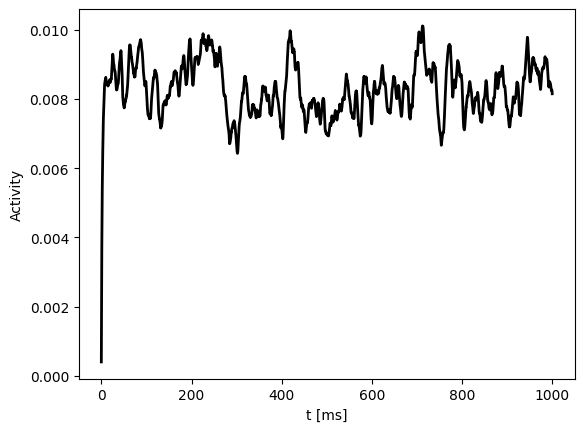

In [39]:
plt.plot(indices * brainstate.environ.get_dt(), exec_activity, c='k', lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")
plt.show()

## Bifurcation diagram

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space.


In [40]:
# these are the different input values that we want to scan
exc_inputs = np.arange(0, 5.5, 0.05)

We sweep a constant excitatory input across multiple independent nodes (one input per node). For each input value we simulate, then record the minimum and maximum of `rE` over time. Plotting min/max against input visualizes fixed points (lines collapsing) versus oscillatory regimes (min/max bands).

Notes:
- Increase simulation duration to better capture oscillation envelopes.
- You can reduce `exc_inputs` resolution for speed during exploration.

In [41]:
nodes = brainmass.WilsonCowanStep(exc_inputs.size)
brainstate.nn.init_all_states(nodes)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update(exc_inputs)


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

In [42]:
max_exc = exec_activity.max(axis=0)
min_exc = exec_activity.min(axis=0)

The resulting diagram shows how steady‑state activity or oscillation amplitude varies with the external excitatory drive.

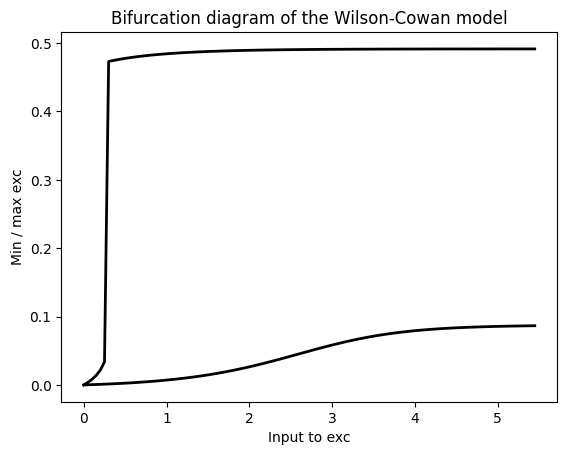

In [43]:
plt.plot(exc_inputs, max_exc, c='k', lw=2)
plt.plot(exc_inputs, min_exc, c='k', lw=2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")
plt.show()

## Load HCP connectome data

In [44]:
import os.path
import kagglehub
path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
data = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

Loading checkpoint from D:\Data\kagglehub\datasets\oujago\hcp-gw-data-samples\versions\1\hcp-data-sample.msgpack


## Brain network

We now couple many Wilson–Cowan nodes according to structural connectivity (weights `Cmat`) and distances `Dmat` from the `hcp` dataset. Delays are derived from distances and a `signal_speed`. We use diffusive coupling on `rE` with per‑edge delays and scale the interaction by a global gain `k`.

In [45]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1.):
        super().__init__()

        conn_weight = data['Cmat'].copy()
        np.fill_diagonal(conn_weight, 0)
        delay_time = data['Dmat'].copy() / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.arange(conn_weight.shape[1])
        indices_ = np.tile(np.expand_dims(indices_, axis=0), (conn_weight.shape[0], 1))

        self.node = brainmass.WilsonCowanStep(
            80,
            noise_E=brainmass.OUProcess(80, sigma=0.01, init=braintools.init.ZeroInit()),
            noise_I=brainmass.OUProcess(80, sigma=0.01, init=braintools.init.ZeroInit()),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time * u.ms, indices_), init=braintools.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

Network dynamics:
- `prefetch_delay('rE', (delay_time, indices))` constructs a delayed view of E‑rates along edges.
- `DiffusiveCoupling` computes inputs from delayed neighbors and scales by `k`.
- The node integrates these inputs and returns `rE`.

In [46]:
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // (brainstate.environ.get_dt() / u.ms))
exes = brainstate.transform.for_loop(net.step_run, indices)

We compute functional connectivity (pairwise correlation) from the simulated `rE` matrix and plot it alongside sample time series. Stronger structure‑function correspondence typically emerges around specific `k` and delay regimes.

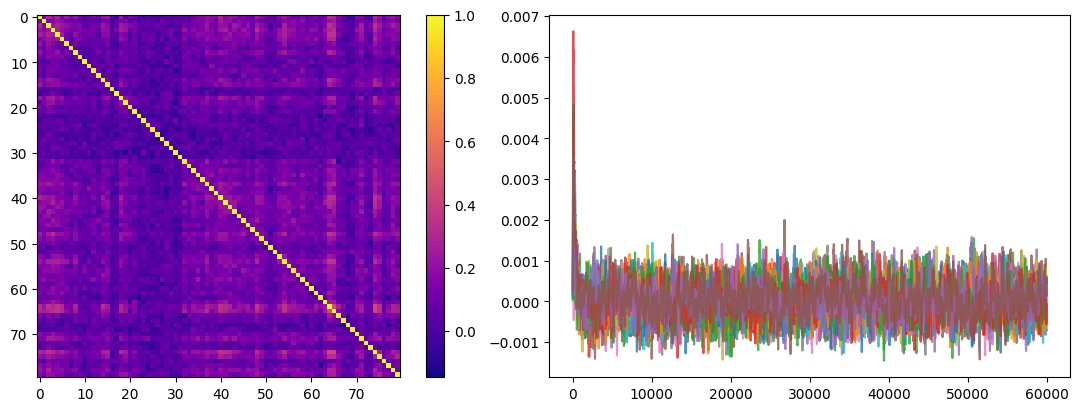

In [47]:
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes[:, ::5], alpha=0.8)
plt.show()